# Libraries and Data

In [2]:
# Libraries
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid


c:\Users\foxhe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [41]:
df = pd.read_csv('../nyc_data.csv')
future_df = pd.read_csv('../future.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [42]:
# merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop=True)
display(df)

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752


In [43]:
# Rename variable
df = df.rename(columns={'Demand': 'y', 'Date': 'ds'})
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [44]:
# Date Varaible
df.ds = pd.to_datetime(df.ds, format='%m/%d/%Y')
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


# Holidays

In [45]:
# Easter
easter_dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter


,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [46]:
#Thanksgiving
tg_dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
tg = pd.DataFrame({'holiday': 'thanksgiving',
                       'ds': tg_dates,
                       'lower_window': -3,
                       'upper_window': 6})
tg

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [47]:
# Combine events to one single Data Frame
holidays = pd.concat([easter, tg])
holidays


,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [48]:
# Remove holidays from dataset
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head()

,ds,y,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,3.68,41.305
1,2015-01-02,581.276773,0,4.73,131.574
2,2015-01-03,754.117039,0,7.23,162.700
3,2015-01-04,622.252774,0,10.96,160.281
4,2015-01-05,785.373319,0,6.92,51.077


# Prophet Model Creation

In [13]:
# Create Model

m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            seasonality_mode='additive',
            seasonality_prior_scale=10,
            holidays_prior_scale=10,
            changepoint_prior_scale=.05)

# Add Regressors
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')

m.fit(df)

12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:53 - cmdstanpy - INFO - Chain [1] done processing


# Cross Validation

In [45]:
# Check observations
df.shape[0] - 180

2012

In [14]:
# cv
df_cv = cross_validation(m, horizon='31 days', period='16 days', initial='2012 days', parallel='processes')
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,619.892443,545.678353,685.926788,571.069531,2020-07-09
1,2020-07-11,732.107621,664.250430,800.403269,677.106981,2020-07-09
2,2020-07-12,649.927632,577.081517,725.080187,619.572774,2020-07-09
3,2020-07-13,779.324515,717.024015,852.909589,808.932621,2020-07-09
4,2020-07-14,651.197379,578.175854,715.483863,661.791644,2020-07-09


In [16]:
metrics = performance_metrics(df_cv, metrics=['rmse'])
metrics.head()

,horizon,rmse
0,4 days,50.596061
1,5 days,52.165149
2,6 days,57.540788
3,7 days,52.183669
4,8 days,49.352455


In [68]:
# RMSE and MAPE
print(f"RMSE: {round(metrics['rmse'].mean(), 1)}")
print(f"MAPE: {round((metrics['mape'].mean() * 100), 2)}%")

RMSE: 50.0
MAPE: 5.55%


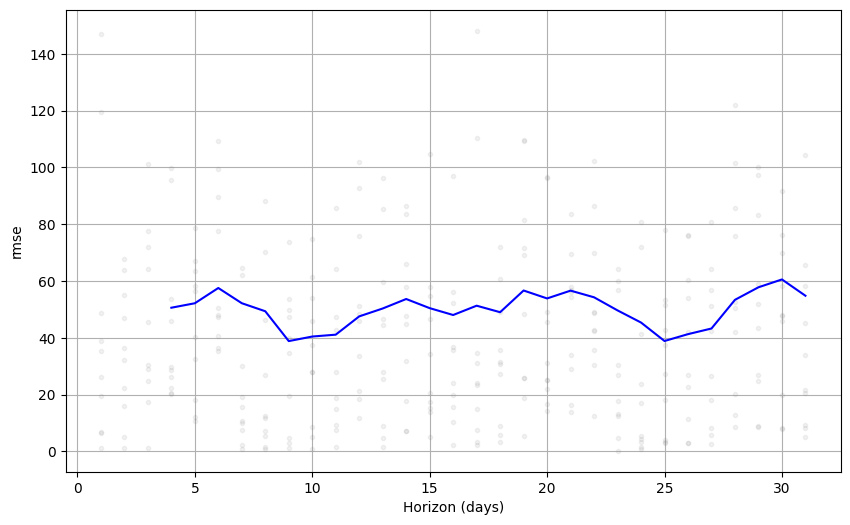

In [70]:
# PLotting
plot_cross_validation_metric(df_cv, metric='rmse');

In [31]:
# Parameter Tuning
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
        'seasonality_prior_scale': [5, 10, 20],
        'holidays_prior_scale': [10, 20, 25],
        'changepoint_prior_scale': [.01, .05, .1]}
grid = ParameterGrid(param_grid=param_grid)


In [25]:
# Parameter Tuning Loop
rmse = []

for index, param in enumerate(grid, start=1):

    # Build Model
    m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            holidays=holidays,
            seasonality_mode=param['seasonality_mode'],
            seasonality_prior_scale=param['seasonality_prior_scale'],
            holidays_prior_scale=param['holidays_prior_scale'],
            changepoint_prior_scale=param['changepoint_prior_scale'])
    
    # Add regressors
    m.add_regressor('Christmas')
    m.add_regressor('Temperature')
    m.add_regressor('Marketing')

    # Fit the model
    m.fit(df)

    # CV & Error extraction
    df_cv = cross_validation(m, horizon='31 days', 
                             period = '16 days', 
                             initial= '2012 days',
                             parallel='processes')
    err = performance_metrics(df_cv, metrics=['rmse'])['rmse'].mean()

    # add error to list
    rmse.append(err)
    print(f"loaded error: {index}")

    
    


12:55:39 - cmdstanpy - INFO - Chain [1] start processing
12:55:39 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 1


12:55:44 - cmdstanpy - INFO - Chain [1] start processing
12:55:44 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 2


12:55:49 - cmdstanpy - INFO - Chain [1] start processing
12:55:49 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 3


12:55:54 - cmdstanpy - INFO - Chain [1] start processing
12:55:54 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 4


12:56:00 - cmdstanpy - INFO - Chain [1] start processing
12:56:00 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 5


12:56:05 - cmdstanpy - INFO - Chain [1] start processing
12:56:05 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 6


12:56:10 - cmdstanpy - INFO - Chain [1] start processing
12:56:10 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 7


12:56:15 - cmdstanpy - INFO - Chain [1] start processing
12:56:15 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 8


12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:20 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 9


12:56:25 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 10


12:56:30 - cmdstanpy - INFO - Chain [1] start processing
12:56:30 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 11


12:56:34 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 12


12:56:39 - cmdstanpy - INFO - Chain [1] start processing
12:56:40 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 13


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 14


12:56:49 - cmdstanpy - INFO - Chain [1] start processing
12:56:49 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 15


12:56:54 - cmdstanpy - INFO - Chain [1] start processing
12:56:54 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 16


12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 17


12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 18


12:57:09 - cmdstanpy - INFO - Chain [1] start processing
12:57:09 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 19


12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 20


12:57:22 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 21


12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 22


12:57:36 - cmdstanpy - INFO - Chain [1] start processing
12:57:36 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 23


12:57:42 - cmdstanpy - INFO - Chain [1] start processing
12:57:43 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 24


12:57:49 - cmdstanpy - INFO - Chain [1] start processing
12:57:49 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 25


12:57:56 - cmdstanpy - INFO - Chain [1] start processing
12:57:56 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 26


12:58:03 - cmdstanpy - INFO - Chain [1] start processing
12:58:03 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 27


12:58:10 - cmdstanpy - INFO - Chain [1] start processing
12:58:10 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 28


12:58:16 - cmdstanpy - INFO - Chain [1] start processing
12:58:17 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 29


12:58:23 - cmdstanpy - INFO - Chain [1] start processing
12:58:23 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 30


12:58:29 - cmdstanpy - INFO - Chain [1] start processing
12:58:30 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 31


12:58:37 - cmdstanpy - INFO - Chain [1] start processing
12:58:37 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 32


12:58:44 - cmdstanpy - INFO - Chain [1] start processing
12:58:45 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 33


12:58:51 - cmdstanpy - INFO - Chain [1] start processing
12:58:52 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 34


12:58:58 - cmdstanpy - INFO - Chain [1] start processing
12:58:59 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 35


12:59:05 - cmdstanpy - INFO - Chain [1] start processing
12:59:05 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 36


12:59:11 - cmdstanpy - INFO - Chain [1] start processing
12:59:12 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 37


12:59:21 - cmdstanpy - INFO - Chain [1] start processing
12:59:22 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 38


12:59:30 - cmdstanpy - INFO - Chain [1] start processing
12:59:31 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 39


12:59:39 - cmdstanpy - INFO - Chain [1] start processing
12:59:39 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 40


12:59:47 - cmdstanpy - INFO - Chain [1] start processing
12:59:47 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 41


12:59:55 - cmdstanpy - INFO - Chain [1] start processing
12:59:56 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 42


13:00:03 - cmdstanpy - INFO - Chain [1] start processing
13:00:03 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 43


13:00:12 - cmdstanpy - INFO - Chain [1] start processing
13:00:13 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 44


13:00:22 - cmdstanpy - INFO - Chain [1] start processing
13:00:23 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 45


13:00:31 - cmdstanpy - INFO - Chain [1] start processing
13:00:32 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 46


13:00:40 - cmdstanpy - INFO - Chain [1] start processing
13:00:41 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 47


13:00:48 - cmdstanpy - INFO - Chain [1] start processing
13:00:48 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 48


13:00:56 - cmdstanpy - INFO - Chain [1] start processing
13:00:57 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 49


13:01:04 - cmdstanpy - INFO - Chain [1] start processing
13:01:05 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 50


13:01:12 - cmdstanpy - INFO - Chain [1] start processing
13:01:13 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 51


13:01:21 - cmdstanpy - INFO - Chain [1] start processing
13:01:21 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 52


13:01:29 - cmdstanpy - INFO - Chain [1] start processing
13:01:29 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 53


13:01:37 - cmdstanpy - INFO - Chain [1] start processing
13:01:37 - cmdstanpy - INFO - Chain [1] done processing


loaded error: 54


In [36]:
# Finding best parameter
params = pd.DataFrame(grid)
params['rmse'] = rmse
best_params = params.iloc[np.argmin(rmse)]
best_params.to_csv("best_params_prophet.csv")

# Create model and forecast

In [63]:
# Training and test Sets
test_days = 31
training = df.iloc[:-test_days, :]
future_df = df.iloc[-test_days:, :]
print(training.tail(1))
print(future_df.head(1))

             ds           y  Christmas  Temperature  Marketing
2191 2020-12-31  783.891494          0         8.22    149.221
             ds   y  Christmas  Temperature  Marketing
2192 2021-01-01 NaN          0          5.0    154.221


In [57]:
# Fetch the parameters
parameters = pd.read_csv('best_params_prophet.csv', index_col=0)
parameters

,12
changepoint_prior_scale,0.01
holidays_prior_scale,25
seasonality_mode,additive
seasonality_prior_scale,5
rmse,48.059989445492874


In [60]:
parameters.loc['seasonality_mode'][0]

'additive'

In [62]:
# Meta model
m = Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode=parameters.loc['seasonality_mode'][0],
            seasonality_prior_scale=float(parameters.loc['seasonality_prior_scale'][0]),
            holidays=holidays,
            holidays_prior_scale=float(parameters.loc['holidays_prior_scale'][0]),
            changepoint_prior_scale=float(parameters.loc['changepoint_prior_scale'][0]))

m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

00:46:31 - cmdstanpy - INFO - Chain [1] start processing
00:46:31 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [65]:
# make a future dataframe
future = m.make_future_dataframe(periods=len(future_df),
                                freq='D') # W for weekly and M for monthly
future = pd.concat([future, df.iloc[:,2:]], axis=1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [66]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.877667,623.080324,757.599866,595.877667,595.877667,0.0,0.0,0.0,-3.547451,...,-4.038172,-4.038172,-4.038172,90.063424,90.063424,90.063424,0.0,0.0,0.0,689.189960
1,2015-01-02,595.992056,539.529540,673.371318,595.992056,595.992056,0.0,0.0,0.0,0.203533,...,-89.437445,-89.437445,-89.437445,88.704556,88.704556,88.704556,0.0,0.0,0.0,605.293350
2,2015-01-03,596.106446,646.912912,785.811913,596.106446,596.106446,0.0,0.0,0.0,1.496924,...,25.264870,25.264870,25.264870,87.510676,87.510676,87.510676,0.0,0.0,0.0,717.819460
3,2015-01-04,596.220836,566.535443,698.541834,596.220836,596.220836,0.0,0.0,0.0,1.396407,...,-55.628882,-55.628882,-55.628882,86.500730,86.500730,86.500730,0.0,0.0,0.0,632.363599
4,2015-01-05,596.335226,692.006575,833.180906,596.335226,596.335226,0.0,0.0,0.0,-3.141391,...,74.316305,74.316305,74.316305,85.688085,85.688085,85.688085,0.0,0.0,0.0,760.935142


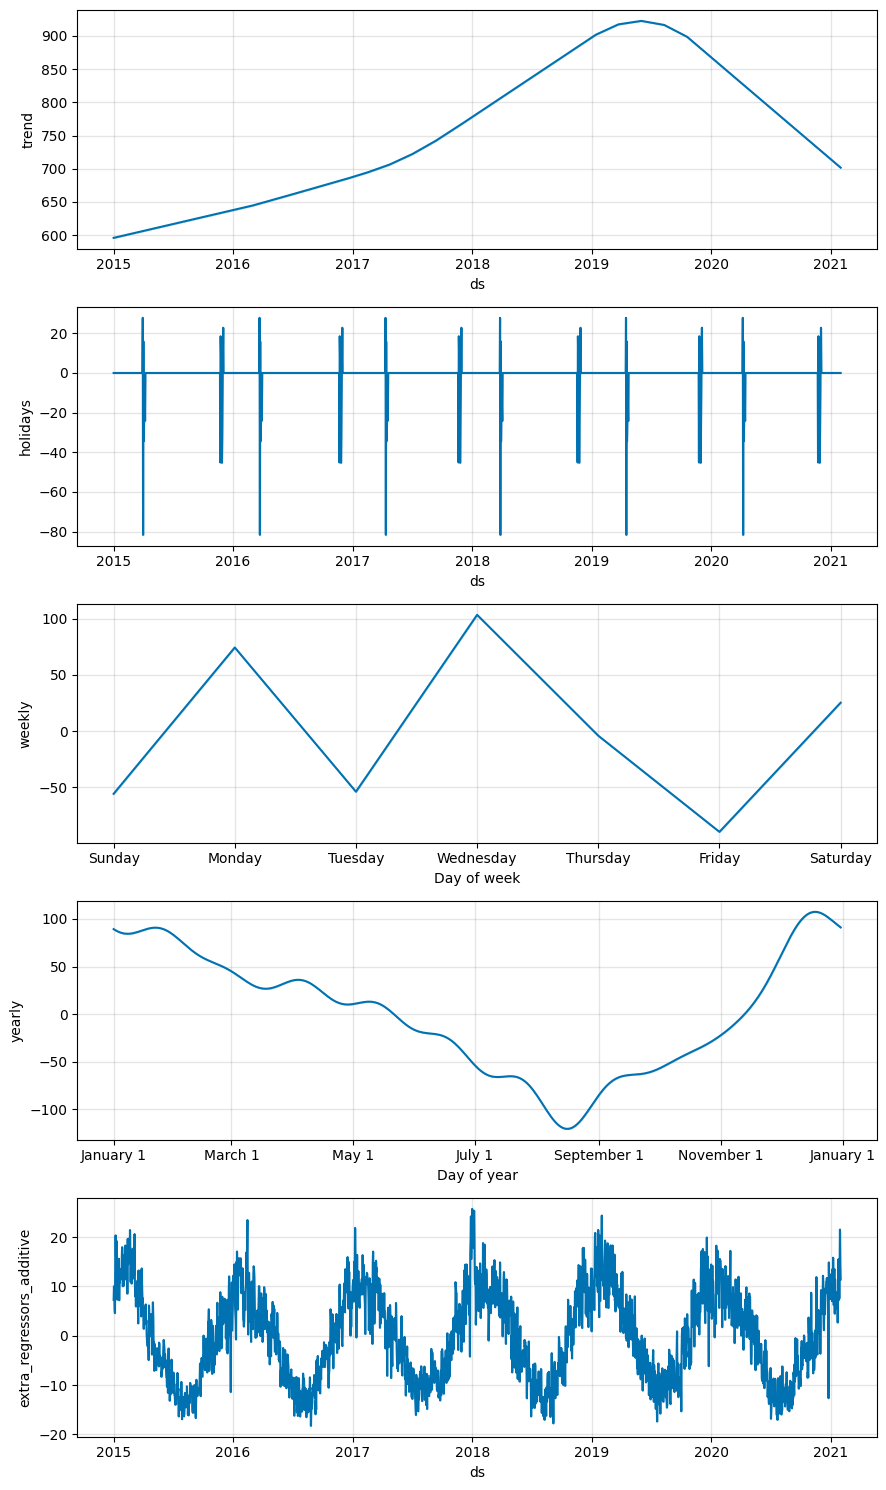

In [68]:
# Plotting 
m.plot_components(forecast);

In [73]:
# extract the predictions
preds_prophet = forecast.yhat[-len(future_df):].rename("prophet")
preds_prophet.index = future_df.ds
preds_prophet

ds
2021-01-01    724.952794
2021-01-02    836.709759
2021-01-03    754.990520
2021-01-04    881.325562
2021-01-05    751.228777
2021-01-06    913.861936
2021-01-07    801.454884
2021-01-08    722.230300
2021-01-09    831.359048
2021-01-10    745.915329
2021-01-11    880.597118
2021-01-12    755.194674
2021-01-13    903.377339
2021-01-14    803.310340
2021-01-15    713.136591
2021-01-16    829.366970
2021-01-17    749.867203
2021-01-18    879.951780
2021-01-19    748.794716
2021-01-20    905.611697
2021-01-21    801.283630
2021-01-22    709.613343
2021-01-23    830.665037
2021-01-24    754.997945
2021-01-25    875.724588
2021-01-26    753.341959
2021-01-27    902.621544
2021-01-28    801.854509
2021-01-29    720.735723
2021-01-30    826.449630
2021-01-31    740.666638
Name: prophet, dtype: float64

In [74]:
# export
preds_prophet.to_csv('predictions_prophet.csv')